# Summarise beta coefficients


In [1]:
import os
import sys
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
from scipy import stats
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
from scipy.stats import gaussian_kde
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _prediction import allNaN_arg

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open data


In [2]:
base='/g/data/os22/chad_tmp/Aus_CO2_fertilisation/'
data_product = 'AusEFlux_GPP_1982_2022' #'AusEFlux_GPP'#'NDVI_1982_2022' 'PML_GPP', 'AusEFlux_GPP_1982_2022'

if 'NDVI' in data_product:
    units='NDVI yr⁻¹ ppm⁻¹'
    units_relative='NDVI % / 100ppm'
else:
    units='GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹'# 'GPP gC m\N{SUPERSCRIPT TWO} yr⁻¹ ppm⁻¹' 'NDVI yr⁻¹ ppm⁻¹'
    units_relative=  'GPP % / 100ppm' # 'GPP % / 100ppm' 'NDVI % / 100ppm'

In [3]:
p_beta = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/beta_{data_product}.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset(f'{base}results/combined_tiles/{data_product}/trends_{data_product}.nc'), crs='EPSG:4326')

# some other enviro datasets for plots
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/WCF_5km_monthly_1982_2022.nc')['WCF']
trees = trees.mean('time')

#veg height
vegh = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/VegH_5km_monthly_1982_2022.nc')['VegH']
vegh = vegh.mean('time')

#aridity index
pet = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/PET_GLEAM_1982_2022.nc')['PET']
rain = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/rain_5km_monthly_1981_2022.nc')['rain']
rain = rain.sel(time=slice('1982','2022'))
pet = pet.sel(time=slice('1982','2022'))
mi = rain/pet
mi = mi.mean('time')
mi = mi.rename('P:PET')
mi = xr.where(mi>5, 5, mi) #remove extreme values
mi = xr.where(mi<0, 0, mi) 

# NDVI data for masking very low ndvi values
ds_path = f'/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022_0.2.0.nc'
ds = assign_crs(xr.open_dataset(ds_path), crs='EPSG:4326')
ds = ds.rename({'AusENDVI_clim_MCD43A4':'NDVI'})
ds = ds['NDVI'].mean('time')
low_ndvi = xr.where(ds<0.125, 1, 0)

### Masking

In [5]:
#where GPP/NDVI trends are positive and significant
positive_mask = xr.where(p_trends.slope > 0, 1, 0)
# sig_mask = xr.where(p_trends.p_value<=0.1, 1, 0)
# sig_mask = (sig_mask & positive_mask)
p_beta = p_beta.where(positive_mask)
p_beta = p_beta.where(~low_ndvi) #remove v.low, sparse eregions

# beta slope is significant?
# significant_beta = xr.where(p_beta['pvalue']<=0.1, 1, 0).astype(bool)
# p_beta = p_beta.where(significant_beta)

#remove any errant betas
beta_zero_mask = xr.where(p_beta['beta']<0, 1, 0)
beta_relative_zero_mask = xr.where(p_beta['beta_relative']<0, 1, 0)
negative_beta_mask = (beta_zero_mask | beta_relative_zero_mask).astype(bool)
beta_huge = xr.where(np.abs(p_beta['beta_relative']>200), 1, 0).astype(bool)

p_beta = p_beta.where(~beta_huge)
p_beta = p_beta.where(~negative_beta_mask)

In [6]:
# np.sum(~np.isnan(p_beta['beta_relative']))

## Plot beta and beta relative

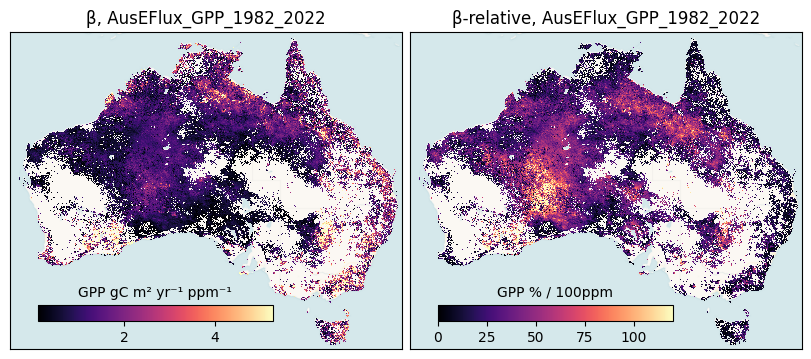

In [7]:
fig,ax=plt.subplots(1,2,figsize=(8,4),layout='constrained', sharey=True, sharex=True)

# vmin=0, vmax=0.015
im = p_beta['beta'].plot(ax=ax[0], add_labels=False, robust=True ,cmap='magma', add_colorbar=False)
ax[0].axes.get_xaxis().set_ticks([])
ax[0].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax[0], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[0].set_title(f'\u03B2, {data_product}')
axins1 = inset_axes(ax[0], width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(units, fontsize=10)

im = p_beta['beta_relative'].plot(ax=ax[1], add_labels=False, vmin=0, vmax=120, cmap='magma', add_colorbar=False)
ax[1].axes.get_xaxis().set_ticks([])
ax[1].axes.get_yaxis().set_ticks([])
ctx.add_basemap(ax[1], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax[1].set_title(f'\u03B2-relative, {data_product}')
axins1 = inset_axes(ax[1], width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title(units_relative, fontsize=10);

fig.savefig(f'{base}results/figs/Beta_{data_product}.png',
            bbox_inches='tight', dpi=300)


## Relationship between environmental gradients and beta

In [8]:
beta_df = p_beta.to_dataframe().drop(['spatial_ref'],axis=1)
beta_df['P:PET'] = mi.where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)
beta_df['WCF'] = trees.where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)
beta_df['VegH'] = vegh.where(~np.isnan(p_beta['beta'])).to_dataframe().drop(['spatial_ref'],axis=1)

beta_df = beta_df.dropna().reset_index(drop=True)

#### Binned bar plots

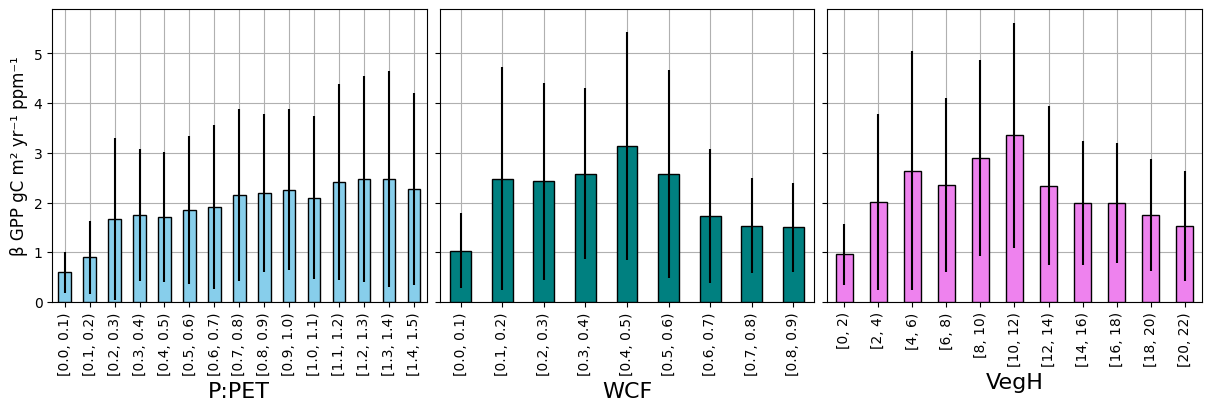

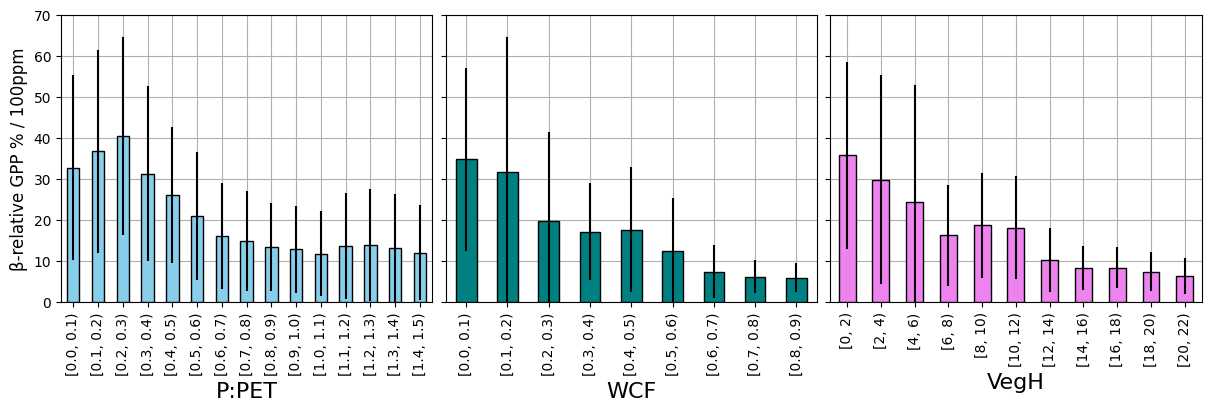

In [9]:
env_vars = ['P:PET', 'WCF', 'VegH']
cls = ['skyblue', 'teal', 'violet']

bins_master = [
    np.arange(0,1.6,0.1),
    np.arange(0,1.0, 0.1),
    np.arange(0,24,2)
    ]

y_vars = ['beta', 'beta_relative']

for y_var in y_vars:
    fig,axes=plt.subplots(1,3, figsize=(12,4),  layout='constrained', sharey=True)
    
    for ev,b,ax,c in zip(env_vars, bins_master, axes.ravel(), cls): 
        bins = pd.cut(beta_df[ev], bins=b, right=False)
        grouped = beta_df.groupby(bins, observed=True)[y_var].mean()
        stddev = beta_df.groupby(bins, observed=True)[y_var].std()
        grouped.plot(kind='bar', color=c, edgecolor='black', ax=ax, zorder=10, yerr=stddev) #
        ax.set_xlabel(ev, fontsize=16)
        ax.grid()
        if y_var=='beta_relative':
            if 'NDVI' in data_product:
                ax.set_ylim(0,105)
            else:
                ax.set_ylim(0,70)
    
    if y_var=='beta':
        axes[0].set_ylabel('\u03B2 '+ units, fontsize=12)
    else:
        axes[0].set_ylabel('\u03B2-relative ' +units_relative, fontsize=12)
        
    fig.savefig(f'{base}results/figs/{y_var}_binned_{data_product}.png',
                        bbox_inches='tight', dpi=300)

### Disaggregated by simple veg groups and bioclimatic zone

Create box plots so we can compare across datasets, environments etc.

### Land cover

In [1]:
lc = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_phenology/data/ESA_WorldCover_processed.nc').drop_vars('band')

NameError: name 'xr' is not defined

In [11]:
lc_names = {
    1:'Trees',
    2:'Shrubs',
    3:'Grasses',
    4:'Sparse',
    5:'Crops'
}

def extract_vars(trends, var, classes_to_extract, lc, nvis_dict):
    dfs = []
    for c in classes_to_extract: #loop through veg classes
        veg_trends = trends.where(lc==c)
        df = veg_trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:nvis_dict[c]},axis=1)
        dfs.append(df)
    
    #now append values for entire continent 
    dfs.append(trends[[var]].drop_vars('spatial_ref').to_dataframe().rename({var:'All'},axis=1))

    return pd.concat(dfs).dropna(axis=0, how='all')

simple_classes_to_plot = [1,2,3]

beta_lc = extract_vars(p_beta, 'beta', simple_classes_to_plot, lc, lc_names)
beta_relative_lc = extract_vars(p_beta, 'beta_relative', simple_classes_to_plot, lc, lc_names)

In [12]:
import matplotlib.patheffects as path_effects

def add_median_labels(ax: plt.Axes, fmt: str = ".1f") -> None:
    """Add text labels to the median lines of a seaborn boxplot.

    Args:
        ax: plt.Axes, e.g. the return value of sns.boxplot()
        fmt: format string for the median value
    """
    lines = ax.get_lines()
    boxes = [c for c in ax.get_children() if "Patch" in str(c)]
    start = 4
    if not boxes:  # seaborn v0.13 => fill=False => no patches => +1 line
        boxes = [c for c in ax.get_lines() if len(c.get_xdata()) == 5]
        start += 1
    lines_per_box = len(lines) // len(boxes)
    for median in lines[start::lines_per_box]:
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if len(set(median.get_xdata())) == 1 else y
        text = ax.text(x, y, f'{value:{fmt}}', ha='center', va='center',
                       color='white') #fontweight='bold'
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

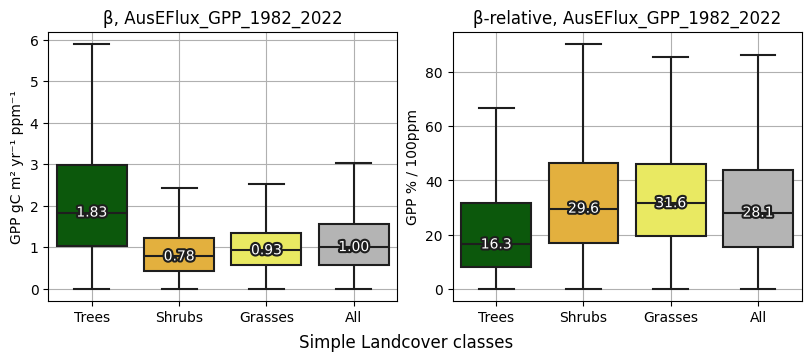

In [13]:
dd = [beta_lc, beta_relative_lc]
names=['beta', 'beta_relative']

categories =['tree', 'shrub', 'grass', 'all'] # 'sparse', 
colours = ['#006400', '#ffbb22', '#ffff4c', '#b4b4b4'] # '#b4b4b4',
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
fig,axes=plt.subplots(1,2, figsize=(8,3.5), layout='constrained', sharex=True)# sharey='row' # 

for d,n,ax in zip(dd,names,axes.ravel()):
    
    if "relative" not in n:
        title=f'\u03B2, {data_product}'
        label=units
        if 'NDVI' in data_product:
            fmt = ".4f"
        else:
            fmt=".2f"
    else:
        title=f'\u03B2-relative, {data_product}'
        label=units_relative
        fmt = ".1f"

    sb.boxplot(d, ax=ax, palette=colours,linewidth=1.5, showfliers=False) #
    ax.set_title(title)
    ax.set_ylabel(label, fontsize=10)
    ax.grid()
    add_median_labels(ax, fmt=fmt)
fig.supxlabel('Simple Landcover classes') 
fig.savefig(f'{base}results/figs/beta_landcover_boxplots_{data_product}.png',
            bbox_inches='tight', dpi=300) 

### Koppen climate zones

In [14]:
# koppen = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_major_climate_zones.nc')
koppen = xr.open_dataarray('/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/koppen_and_landcover.nc')#.drop_vars('band')

In [15]:
koppen_names = {
    50:'Desert',
    51:'Grassland',
    52:'Temperate',
    53:'Subtropical',
    54:'Tropical',
    55:'Equatorial'
}

koppen_classes_to_plot = [50,51,52,53,54,55]

beta_koppen = extract_vars(p_beta, 'beta', koppen_classes_to_plot, koppen, koppen_names)
beta_relative_koppen = extract_vars(p_beta, 'beta_relative', koppen_classes_to_plot, koppen, koppen_names)

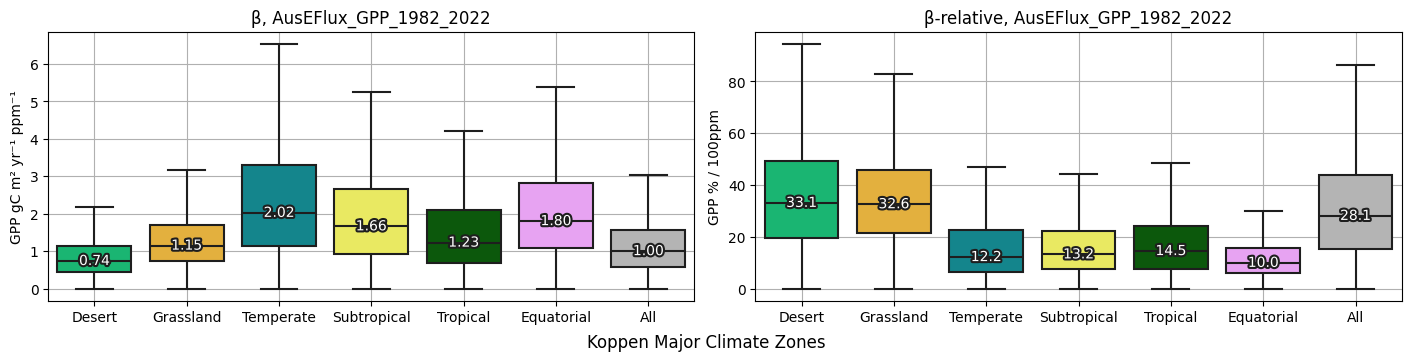

In [16]:
dd = [beta_koppen, beta_relative_koppen]
names=['beta', 'beta_relative']

categories =['Desert', 'Grassland', 'Temperate', 'Subtropical', 'Tropical', 'Equatorial', 'all'] 
colours = ['#00cf75' ,  '#ffbb22',   '#0096a0',     '#ffff4c',  '#006400'  ,   '#f096ff', '#b4b4b4']#  '#0096a0', '#00cf75',  '#ffff4c'
cmap = LinearSegmentedColormap.from_list("landcover_cmap", colours, N=len(colours))

flierprops = dict(markerfacecolor='0.75', markersize=3, linestyle='none')
fig,axes=plt.subplots(1,2, figsize=(14,3.5), layout='constrained', sharex=True)# sharey='row' # 

for d,n,ax in zip(dd,names,axes.ravel()):
    
    if "relative" not in n:
        title=f'\u03B2, {data_product}'
        label=units
        if 'NDVI' in data_product:
            fmt = ".4f"
        else:
            fmt=".2f"
    else:
        title=f'\u03B2-relative, {data_product}'
        label=units_relative
        fmt = ".1f"

    sb.boxplot(d, ax=ax, palette=colours,linewidth=1.5, showfliers=False) #
    ax.set_title(title)
    ax.set_ylabel(label, fontsize=10)
    ax.grid()
    add_median_labels(ax, fmt=fmt)
fig.supxlabel('Koppen Major Climate Zones') 
fig.savefig(f'{base}results/figs/beta_koppen_boxplots_{data_product}.png',
            bbox_inches='tight', dpi=300) 

#### Scatter plots

In [17]:
# df = beta_df.sample(10000)

In [18]:
# y_var = 'beta'
# vars = ['P:PET', 'Trees', 'VegH']
# fig,axes=plt.subplots(1,3, figsize=(9,3),  layout='constrained', sharey=True)
# for k, ax in zip(vars, axes.ravel()):

#     obs,pred = df[k].values, df[y_var].values
#     mask = ~np.isnan(obs) & ~np.isnan(pred)
#     sl, i, r, p, s = stats.linregress(obs[mask],pred[mask])
#     r2 = r**2
    
#     xy = np.vstack([obs[mask],pred[mask]])
#     z = gaussian_kde(xy)(xy)
    
#     sb.scatterplot(data=df, y=y_var, x=k, alpha=0.5, ax=ax, c=z, cmap='magma')
#     sb.regplot(data=df, y=y_var, x=k,  scatter=False,
#                line_kws={'linewidth':1}, color='blue', ax=ax, robust=False, ci=None)
#     ax.grid()
#     if y_var=='beta_relative':
#         ax.set_ylim(-1, 200)
#     else:
#         ax.set_ylim(-0.001, 0.05)
#     ax.set_ylabel(None)
#     ax.set_xlabel(k, fontsize=12)
#     ax.text(.70, .90, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(r2),
#             transform=ax.transAxes, fontsize=12)
#     ax.text(.70, .825, 'p={:.3f}'.format(p), transform=ax.transAxes, fontsize=12);

# if y_var=='beta':
#     axes[0].set_ylabel(units, fontsize=12)
# else:
#     axes[0].set_ylabel(units_relative, fontsize=12)